# HPC Mini-Challenge 2 - Beschleunigung in Data Science
#### FHNW - FS2024

Original von S. Suter, angepasst von S. Marcin und M. Stutz

### Ressourcen
* HPC mit Python – days 1-2 ([Videos](https://www.youtube.com/playlist?list=PL1tk5lGm7zvSC4rLm5Y71372R1Yxl2Dg_), [Github](https://github.com/eth-cscs/PythonHPC)), 2020:
    - JupyterLab Tutorial (z.B. GPU Ressourcen)
    - Introduction
    - Vectorization
    - Profiling
    - JIT Numba CPU 1 + 2
    - Siehe auch aktuelles Tutorial von 2021

Abgabe von: <font color='blue'>Dominik Filliger</font>


## Ausgangslage/Problemstellung


Das menschliche Gehirn verliert mit zunehmendem Alter an Funktion. Ein Teil davon ist "gesundes Altern", d.h. es passiert bei jedem Menschen. Ein relativ großer Prozentsatz der alternden Bevölkerung erlebt jedoch auch einen kognitiven Rückgang, der extremer ist als bei anderen. Eine mildere Version davon wird als 'leichte kognitive Beeinträchtigung' (MCI) bezeichnet, bei der die Person grösstenteils noch funktionieren kann. Bei einem Teil der MCI-Patienten schreitet die Krankheit fort und führt zu Demenz bzw. Alzheimer. In diesem Projekt liegen uns MRI-Bilder des Gehirns von Alzheimerpatienten vor. Im spezifischen analysieren wir die Entwicklung von Alzheimer-Patienten anhand von MRI-Bildern, welche über eine bestimmte Zeit zur Verfügung stehen. Es stellt sich die Frage, wie gut sich die Veränderungen des Krankheitsbildes mittels Korrelationen über die Bildanalyse zeigen lassen. Zur Analyse sind Gigabytes von Daten in Form von 3D Gehirn-Scans vorhanden. Die Verarbeitung dieser grossen Datenmengen kann von Komprimierung profitieren.

Das Verständnis von Gedächtnis- und Kognitionsstörungen und die Möglichkeit, den Gesundheitszustand des Gehirns zu erkennen, vorherzusagen und zu überwachen, ist ein gesellschaftlich und wirtschaftlich relevantes Thema der angewandten Wissenschaft. Alle neuen Erkenntnisse, die datenwissenschaftliche Methoden liefern können, werden zur Entwicklung von Lösungen beitragen, mit denen die Gesundheit des Gehirns erkannt, vorhergesagt und überwacht werden kann.

### Daten
[ADNI (Alzheimer's Disease Neuroimaging Initiative)](https://adni.loni.usc.edu/) ist ein internationales Projekt zur Erfassung von Daten über die Alzheimer-Krankheit und andere verwandte Gehirnerkrankungen, die zu einem kognitiven Abbau führen. Die Initiative wurde mit grossem Enthusiasmus aufgenommen, und viele Mitarbeiter aus der ganzen Welt haben Daten zur Verfügung gestellt, die sie in ihren eigenen Forschungsteams gesammelt haben. Die ADNI-Initiative ist ein öffentliches (gemeinnütziges) Projekt, da viele Forschungseinrichtungen auf der ganzen Welt mit Steuergeldern dazu beigetragen haben. Das bedeutet zwei Dinge: Die Daten stehen uns zwar für Forschungs- und Bildungszwecke zur Verfügung, aber wir dürfen die Daten **nicht** an andere weitergeben oder kommerzialisieren.



***Wichtig!*** Die Studierenden dürfen die Daten nur für Forschungszwecke verwenden und erhalten nur einen Beispielsdatensatz. Die ADNI-Daten dürfen nur lokal auf dem Computer oder auf FHNW-Ressourcen wie dem GitLab-Repository, d.h. nicht auf Github, gespeichert werden. Siehe [ADNI Datennutzungsvereinbarung](https://adni.loni.usc.edu/wp-content/uploads/how_to_apply/ADNI_Data_Use_Agreement.pdf).


<img src="images/mri-example.png" alt="MRI example image (coronal slice)" width="150"/> <img src="images/slicing.png" alt="Slicing" width="400"/>

Links: MRI Beispielbild (coronaler Schnitt), rechts: MRI slicing

## Zielsetzung

In dieser Aufgabe sollen die Parallelisierung und Beschleunigung unterschiedlicher Methoden von Bildrekonstruktion basierend auf komprimierten (zerlegten) Daten implementiert, analyisiert und diskutiert werden. Die Rekonstruktion der Daten aus der komprimierten Version soll dabei möglichst in Echtzeit geschehen. 

## Lösungsweg / Vorgehen

Wir lösen diese Aufgabenstellung indem wir die Singulärwertzerlegung (SVD: singular value decomposition) als Kompressionsmethode verwenden (Matrixfaktorisierung). Siehe Abbildungen unten. Um die Rekonstruktion der Daten aus der SVD-Matrixfaktoriseriung möglichst in Echtzeit zu bewerkstelligen, evaluieren wir dafür verschiedene Methoden der Parallelisierung und Beschleunigung in Python. 
* Beschleunigungsvarianten auf der CPU:
    - Numpy Operationen inkl. Broadcasting
    - Numba
    - Threads
* Beschleunigung auf der GPU:
    - Cupy (analog zu Numpy)
    - Numba (analog zu Numba)

<img src="images/svd_reco.png" alt="svd vis" width="300"/> <img src="images/svd.png" alt="svd" width="300"/>

## Daten Zerlegen
### 1.1 Daten laden


In [1]:
import os
import imageio.v3 as imageio
import numpy as np
import glob

subfolder = '001'
folders = os.path.join('adni_png', subfolder)

# Get all PNGs from 001 with 145 in the name
files = sorted(glob.glob(f"{folders}/*145.png"))

# Load all images using ImageIO and create a numpy array from them
images = np.array([imageio.imread(f) for f in files])

# Get all the names of the files
names = [f[-17:-4] for f in files]

print(images.shape)

(7, 256, 170)


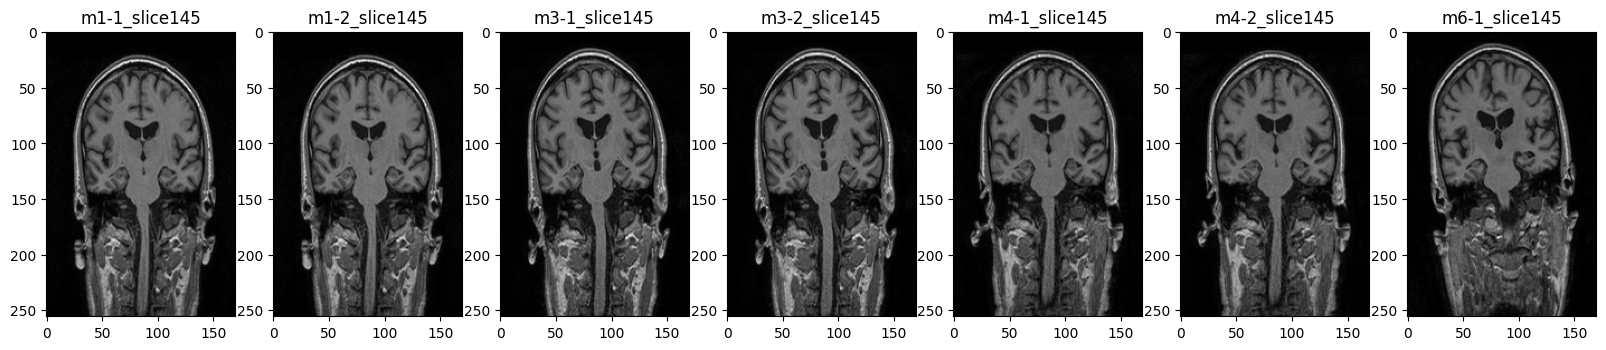

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,10))

for a in range(images.shape[0]):
    ax = fig.add_subplot(1,images.shape[0],a+1)
    ax.imshow(images[a],cmap='gray')
    ax.set_title(names[a])


### 1.2 Daten zerlegen

In [3]:
def reconstruct_svd(u,s,vt,k):
    """SVD reconstruction for k components using np.dot()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    reco = np.dot(u[...,:k], np.dot(np.diag(s[:k]), vt[:k,...]))
        
    return reco

In [4]:
from skimage import metrics

# calculate various metrics for the reconstruction quality
def calculate_metrics(im, reco):
    mse = metrics.mean_squared_error(im, reco)
    ssim_score = metrics.structural_similarity(im, reco, data_range=1)
    hdist = metrics.hausdorff_distance(im, reco)
    return f"MSE: {mse:.2f}, SSIM {ssim_score:.2f}, HDIST: {hdist:.2f}"


original size:  43520
decomposed to n =  170 , size:  72590
decomposed to n =  140 , size:  59780
decomposed to n =  110 , size:  46970
decomposed to n =  80 , size:  34160
decomposed to n =  50 , size:  21350


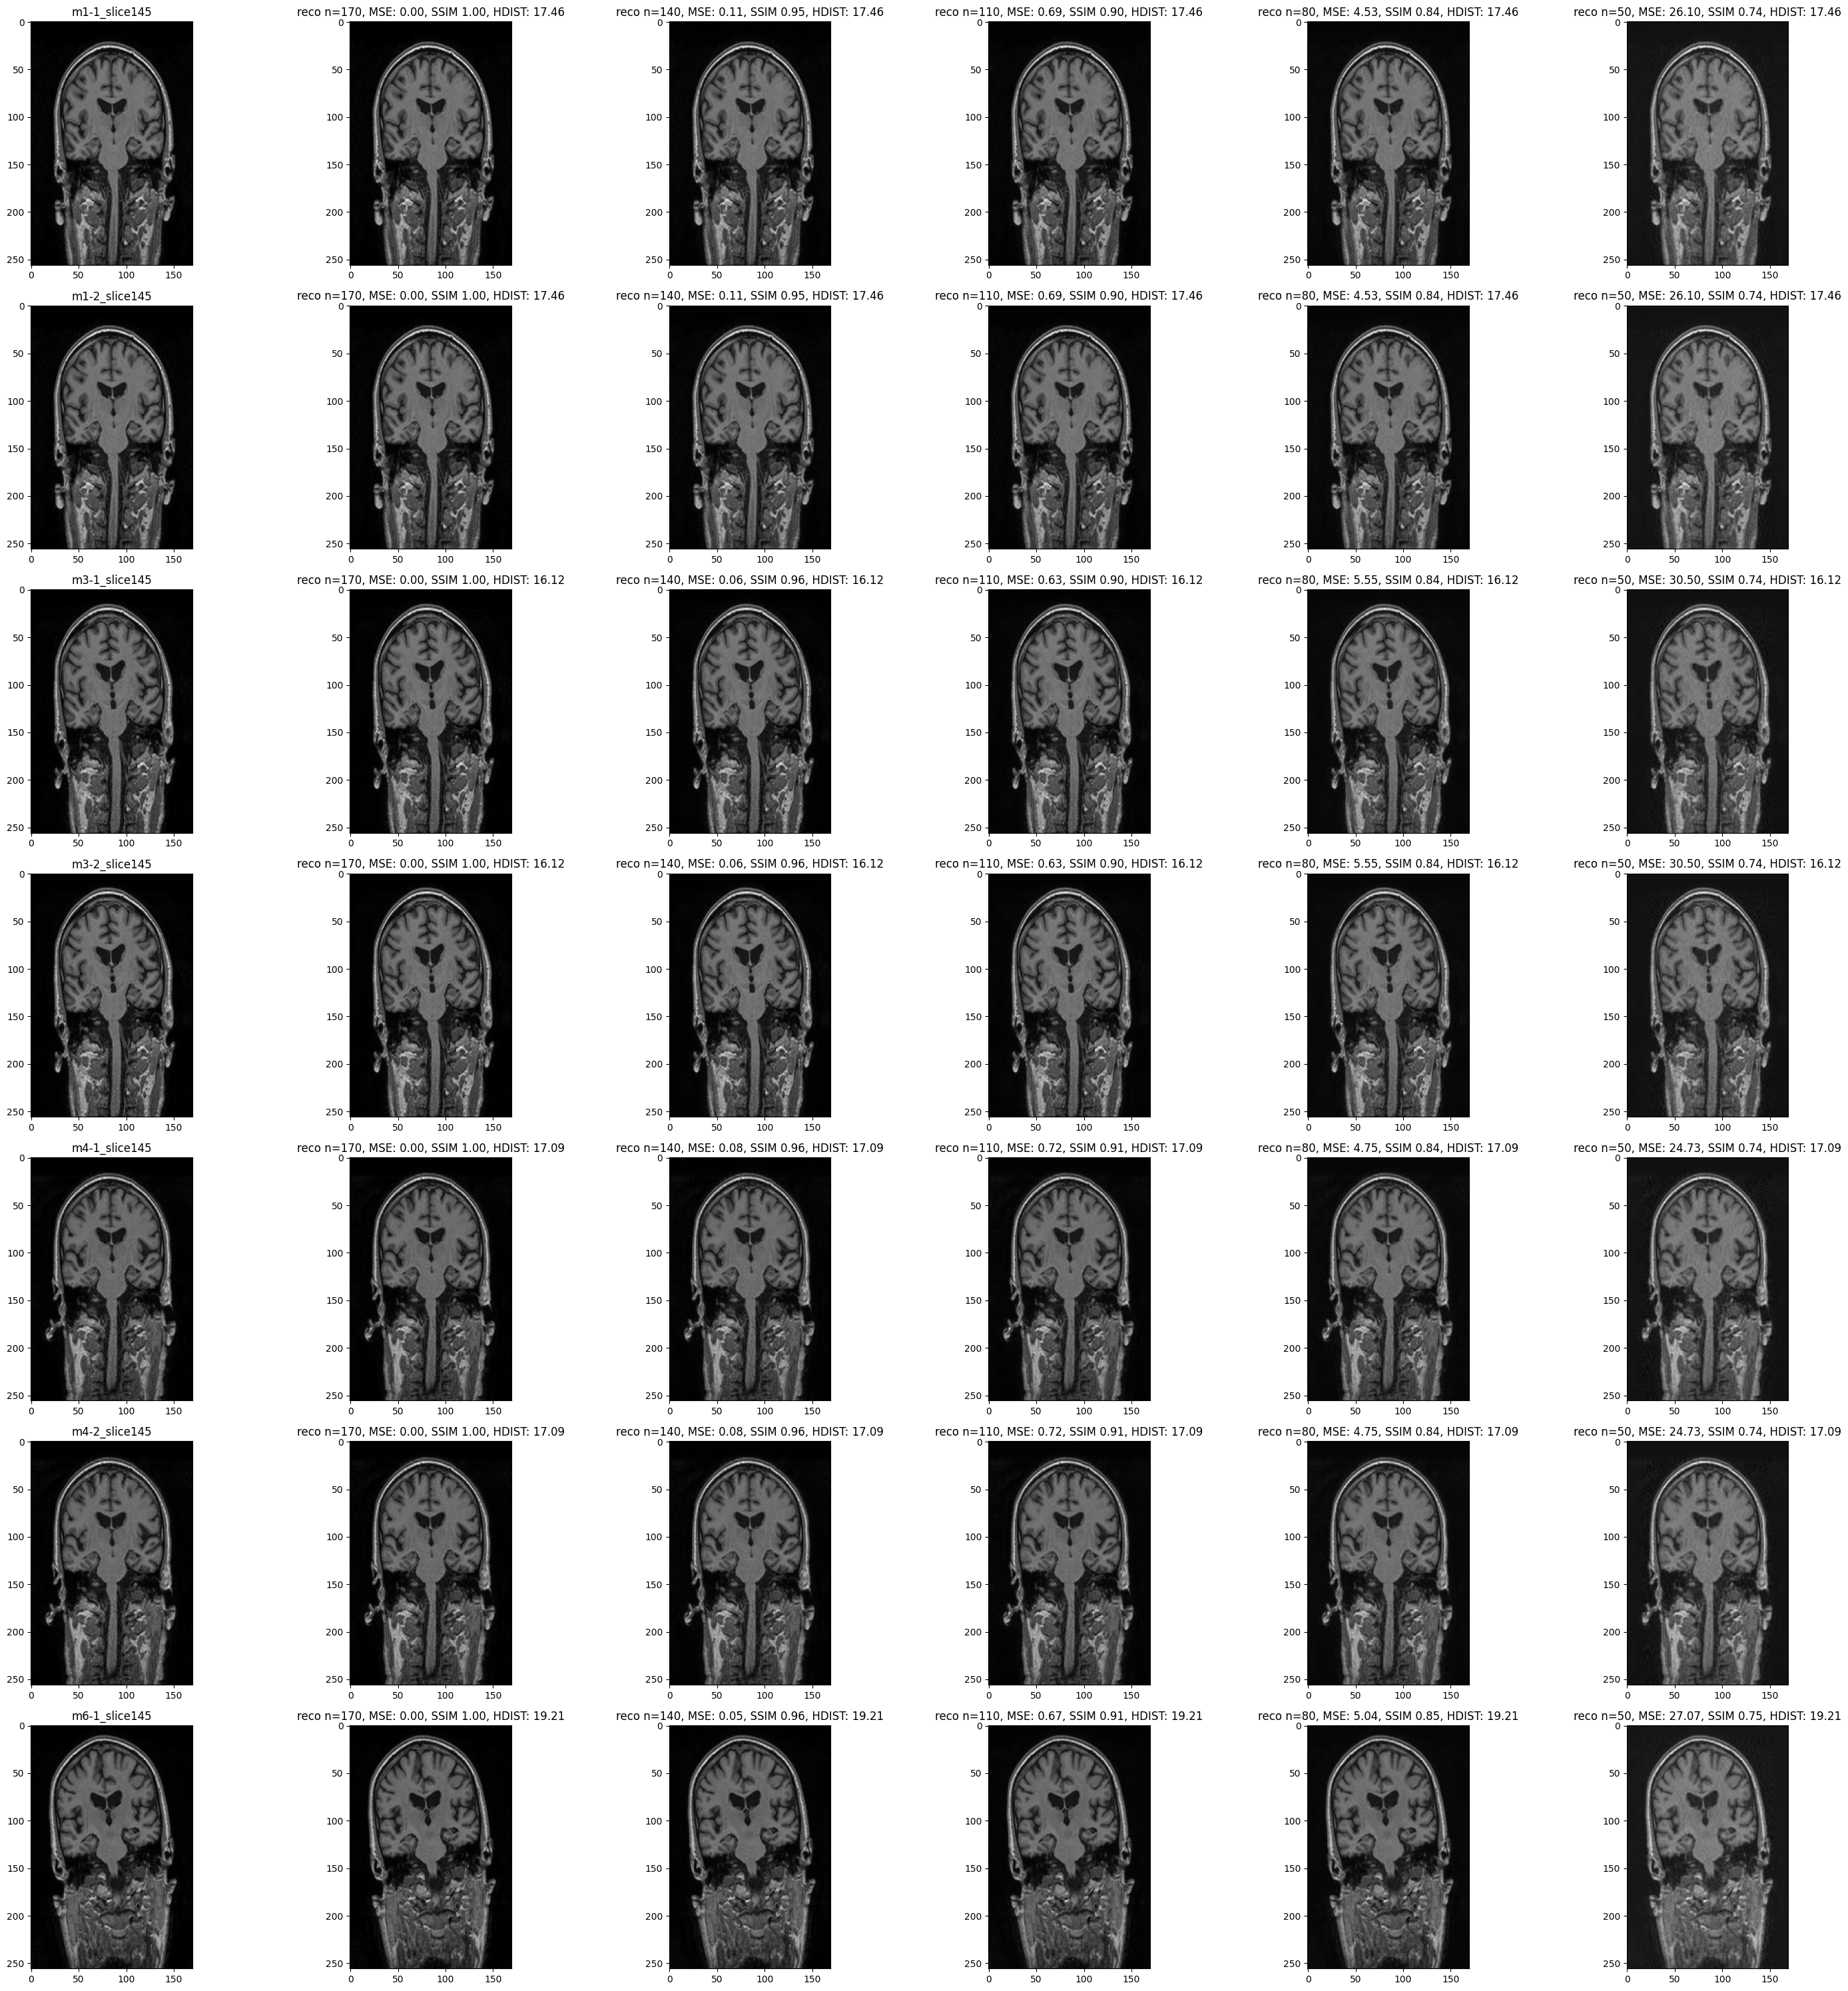

In [5]:
fig, axs = plt.subplots(images.shape[0], 6, figsize=(30,30))

for a in range(images.shape[0]):
    im = images[a]
    im = im - im.min() / im.max() - im.min()  # normalize image
    u, s, vt = np.linalg.svd(im, full_matrices=False)

    axs[a, 0].imshow(im,cmap='gray')
    axs[a, 0].set_title(names[a])
    
    if (a == 0):
        print('original size: ', im.shape[0]*im.shape[1])
    
    for idx, n in enumerate(range(s.shape[0], 20, -30)):
        reconstruct = reconstruct_svd(u,s,vt,n)
        if (a == 0):
            print('decomposed to n = ', n , ', size: ', u.shape[0] * n + n + vt.shape[0]*n)
    
        axs[a, idx+1].imshow(reconstruct,cmap='gray')
        axs[a, idx+1].set_title('reco n=' + str(n) + ', ' + calculate_metrics(im, reconstruct))
plt.tight_layout()


### 2 Rekonstruktionsvarianten
Siehe Bilder in der Einführung (Teil: Vorgehen).

In [6]:
# helper function to visualze reconstruction
def plot_reco(reco, k):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(reco,cmap='gray')
    ax.set_title('reco with ' + str(k)+ ' components')

#### 2.1 For-Loops
Rekonstruiere nun die zerlegte SVD Matrix mittels For-Loops gemäss Formel B.4 (oben). Rekonstruiere nur die ersten $k$ Komponenten der SVD-Matrixfaktorisierung $U, S, V^T$, wobei $U \in \mathbb{R}^{MxN}$, $S \in \mathbb{R}^{N}$, und  $V^T \in \mathbb{R}^{NxN}$. 

Implementiere dafür folgende drei Funktionen - jeweils mit 3, 2 bzw. 1 For-Loop:

In [7]:
def reconstruct_svd_for_loops3(u,s,vt,k):
    """SVD reconstruction for k components using 3 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION

    m, n = u.shape
    reco = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            for l in range(k):
                reco[i, j] += s[l] * u[i, l] * vt[l, j] 
            
    ### END SOLUTION

    return reco

In [8]:
def reconstruct_svd_for_loops2(u,s,vt,k):
    """SVD reconstruction for k components using 2 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION

    m, n = u.shape
    reco = np.zeros((m, n))

    for i in range(m):
        for l in range(k):
            reco[i, :] += s[l] * u[i, l] * vt[l, :] 

    ### END SOLUTION

    return reco

In [9]:
def reconstruct_svd_for_loops1(u,s,vt,k):
    """SVD reconstruction for k components using 1 for-loop and np.outer()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION

    m, n = u.shape
    reco = np.zeros((m, n))

    for l in range(k):
        reco += s[l] * np.outer(u[:, l], vt[l, :])
 
        
    ### END SOLUTION

    return reco

#### 2.2 Einstein Summation
Implementiere nun eine möglichst schnelle Rekonstruktionsvariante mittels `np.einsum()` gemäss folgender Funktion:

In [10]:
def reconstruct_svd_einsum1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = np.einsum("ik,k,kl->il", u[:, :k], s[:k], vt[:k, :])
    ### END SOLUTION

    return reco

#### 2.3 Broadcasting
Implementiere nun zwei Rekonstruktionsvarianten mittels Broadcasting.

Links:
- https://machinelearningmastery.com/broadcasting-with-numpy-arrays/
- https://numpy.org/doc/stable/user/basics.broadcasting.html
- https://eli.thegreenplace.net/2015/broadcasting-arrays-in-numpy/
- https://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc

In [11]:
def reconstruct_svd_broadcast1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 1
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = u[:, :k] * s[:k] @ vt[:k, :]
    ### END SOLUTION

    return reco

In [12]:
def reconstruct_svd_broadcast2(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 2
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = u[:, :k] @ (s[:k].reshape((-1, 1)) * vt[:k, :])
    ### END SOLUTION

    return reco


#### 2.4 Vergleich der Resultate
Vergleiche die Resultate der Implementierungen anhand eines Beispielbildes. Sind die Rekonstruktionen nahezu gleich? Wie sieht es mit der Rekonstruktionsgeschwindigkeit aus - abhängig von der Anzahl rekonstruierter Komponenten?

Components: 100%|██████████| 91/91 [01:24<00:00,  1.07it/s]


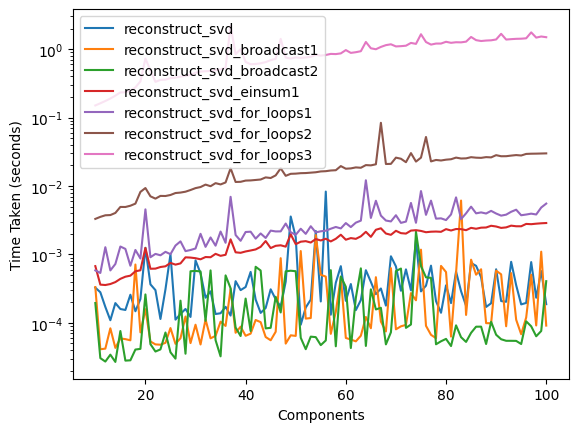

In [13]:
### BEGIN SOLUTION
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timeit
from tqdm import tqdm


def measure_reconstruction_time(model, u, s, vt, num_components):
    start = timeit.default_timer()
    model(u, s, vt, num_components)
    end = timeit.default_timer()
    return end - start


models = [
    reconstruct_svd,
    reconstruct_svd_for_loops3,
    reconstruct_svd_for_loops2,
    reconstruct_svd_for_loops1,
    reconstruct_svd_einsum1,
    reconstruct_svd_broadcast1,
    reconstruct_svd_broadcast2,
]

df = pd.DataFrame(columns=["Model", "Components", "Time Taken"], dtype=object)

for num_components in tqdm(range(10, 101), desc="Components"):
    for model in models:
        name = model.__name__
        time_taken = measure_reconstruction_time(model, u, s, vt, num_components)
        df.loc[len(df)] = [name, num_components, time_taken]

for name, time_list in df.groupby("Model")["Time Taken"]:
    plt.plot(range(10, 101),time_list, label=name)

plt.xlabel("Components")
plt.ylabel("Time Taken (seconds)")
plt.yscale("log")
plt.legend()
plt.show()
### END SOLUTION

In [14]:
### BEGIN SOLUTION
assert np.allclose(reconstruct_svd(u, s, vt, 10), reconstruct_svd_for_loops3(u, s, vt, 10))
assert np.allclose(reconstruct_svd(u, s, vt, 10), reconstruct_svd_for_loops2(u, s, vt, 10))
assert np.allclose(reconstruct_svd(u, s, vt, 10), reconstruct_svd_for_loops1(u, s, vt, 10))
assert np.allclose(reconstruct_svd(u, s, vt, 10), reconstruct_svd_einsum1(u, s, vt, 10))
assert np.allclose(reconstruct_svd(u, s, vt, 10), reconstruct_svd_broadcast1(u, s, vt, 10))
assert np.allclose(reconstruct_svd(u, s, vt, 10), reconstruct_svd_broadcast2(u, s, vt, 10))
### END SOLUTION

#### 2.5 Interpretation der Resultate

Welche der Implementierungen war am schnellsten? Was waren deine Beobachtungen während  der Implementierung? Wo können solche Optimierungen sonst noch eingesetzt werden? Diskutiere in ca. 150-200 Wörtern.

<font color='blue'>
The plot shows the different reconstruction times for the different methods (y-axis is log-scaled for better visibility). The for-loops are the slowest. The broadcasting methods are the fastest, closely followed by the einsum method. The original SVD method is the slowest, but still faster than the for-loops. The asserts prove that all the methods yield the same result.

Interpretation:
TODO
</font>


### 3 Parallelisierung mittels Numba

Implementiere nun eine möglichst schnelle Rekonstruktionsvariante des SVDs mittels Numba. Ist es möglich, den Code mit Numba zu beschleunigen? Führe dazu eine Diagnostik aus. Wenn ja, was ist der Speedup-Faktor und welche(r) Teil(e) konnte(n) parallelisiert werden? Falls nein, was sind die Gründe, weshalb es sich nicht parallelisieren lässt? Lassen sich verschachtelte Schleifen parallelisieren? Warum? Diskutiere in ca. 150-200 Wörtern, wann und warum sich Numba für die Parallelisierung eignet - anhand deines Beispiels.

Beachte:
* Beim ersten Mal Ausführen des Codes wird die Zeit des Kompilierens mit eingerechnet.
* Numba eignet sich gut für For-Schleifen

In [41]:
import numba
from numba import prange
from numba import njit

### BEGIN SOLUTION

@njit
def reconstruct_svd_numba_without_loops(u, s, vt, k):
    """SVD reconstruction for k components using Numba

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    u = np.ascontiguousarray(u)
    s = np.ascontiguousarray(s)
    vt = np.ascontiguousarray(vt)

    reco = np.dot(u[..., :k], np.dot(np.diag(s[:k]), vt[:k, ...]))

    return reco

@njit(parallel=True, nopython=True, fastmath=True, cache=True)
def reconstruct_svd_numba_optimized(u, s, vt, k):
    u = np.ascontiguousarray(u)
    s = np.ascontiguousarray(s)
    vt = np.ascontiguousarray(vt)

    m, n = u.shape
    u_k = u[:, :k]
    s_k = s[:k]
    vt_k = vt[:k, :]

    reco = np.zeros((m, n), dtype=u.dtype)
    
    for i in prange(m):
        for j in prange(n):
            sum = 0.0
            for l in prange(k):
                sum += s_k[l] * u_k[i, l] * vt_k[l, j]
            reco[i, j] = sum

    return reco

### END SOLUTION
@njit(parallel=True, nopython=True)
def reconstruct_svd_numba(u,s,vt,k):
    """SVD reconstruction for k components using numba
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    m, n = u.shape
    u_k = u[:, :k]
    s_k = s[:k]
    vt_k = vt[:k, :]

    reco = np.zeros((m, n))
    for i in prange(m):
        for j in prange(n):
            sum = 0.0
            for l in prange(k):
                sum += s_k[l] * u_k[i, l] * vt_k[l, j]
            reco[i, j] = sum
    ### END SOLUTION

    return reco

/Users/dmnk/PycharmProjects/hs24-mc2-dmnkf/.venv/lib/python3.12/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


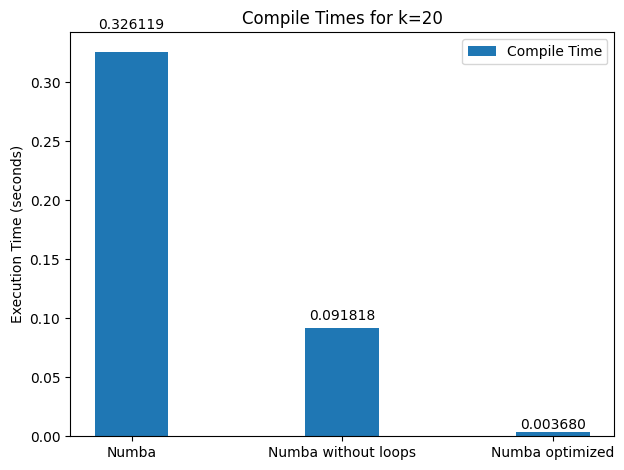

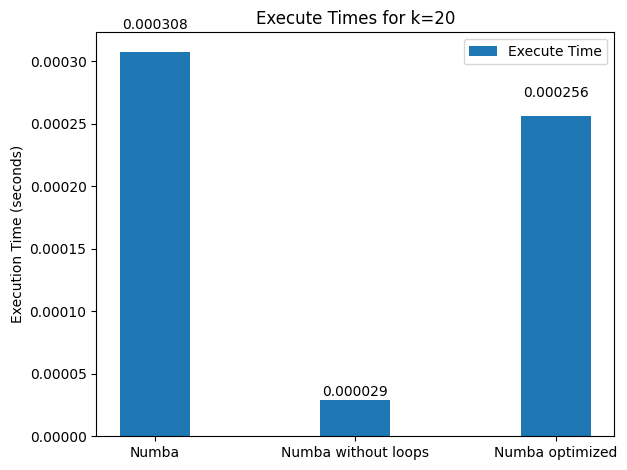

In [42]:
k = 20


def time_execution(func, *args):
    """Times the execution of a function.

    Inputs:
    func: function to time
    *args: arguments to pass to the function

    Output:
    execution time in seconds
    """
    start_time = timeit.default_timer()
    func(*args)
    end_time = timeit.default_timer()

    return end_time - start_time


# The first execution is the compile time, the second is the execution time as it is cached
execution_times = {
    "Numba with compile time": time_execution(reconstruct_svd_numba, u, s, vt, k),
    "Numba execute time": time_execution(reconstruct_svd_numba, u, s, vt, k),
    "Numba with compile time without loops": time_execution(reconstruct_svd_numba_without_loops, u, s, vt, k),
    "Numba execute without loops time": time_execution(reconstruct_svd_numba_without_loops, u, s, vt, k),
    "Numba optimized with compile time": time_execution(reconstruct_svd_numba_optimized, u, s, vt, k),
    "Numba optimized execute time": time_execution(reconstruct_svd_numba_optimized, u, s, vt, k),
}

# Plotting the execution times with grouped compile and execute times
import matplotlib.pyplot as plt

labels = ['Numba', 'Numba without loops', 'Numba optimized']
compile_times = [execution_times["Numba with compile time"], execution_times["Numba with compile time without loops"], execution_times["Numba optimized with compile time"]]
execute_times = [execution_times["Numba execute time"], execution_times["Numba execute without loops time"], execution_times["Numba optimized execute time"]]

# Plot for compile times
fig, ax = plt.subplots()
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
rects1 = ax.bar(x, compile_times, width, label='Compile Time')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution Time (seconds)')
ax.set_title(f'Compile Times for k={k}')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding values on top of each bar
for rect in rects1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%f' % height,
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plot for execute times
fig, ax = plt.subplots()
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
rects2 = ax.bar(x, execute_times, width, label='Execute Time')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution Time (seconds)')
ax.set_title(f'Execute Times for k={k}')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding values on top of each bar
for rect in rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%f' % height,
            ha='center', va='bottom')

plt.tight_layout()
plt.show()



Components: 100%|██████████| 91/91 [01:22<00:00,  1.10it/s]


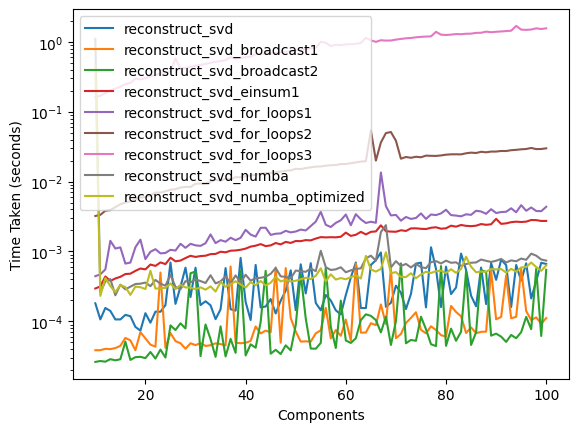

In [16]:
### BEGIN SOLUTION
models = [
    reconstruct_svd,
    reconstruct_svd_for_loops3,
    reconstruct_svd_for_loops2,
    reconstruct_svd_for_loops1,
    reconstruct_svd_einsum1,
    reconstruct_svd_broadcast1,
    reconstruct_svd_broadcast2,
    reconstruct_svd_numba,
    reconstruct_svd_numba_optimized,
]

model_names = [
    "reconstruct_svd",
    "reconstruct_svd_for_loops3",
    "reconstruct_svd_for_loops2",
    "reconstruct_svd_for_loops1",
    "reconstruct_svd_einsum1",
    "reconstruct_svd_broadcast1",
    "reconstruct_svd_broadcast2",
    "reconstruct_svd_numba_without_loops",
    "reconstruct_svd_numba",
    "reconstruct_svd_numba_optimized",
]

df = pd.DataFrame(columns=["Model", "Components", "Time Taken"], dtype=object)

for num_components in tqdm(range(10, 101), desc="Components"):
    for model in models:
        name = model.__name__
        time_taken = measure_reconstruction_time(model, u, s, vt, num_components)
        df.loc[len(df)] = [name, num_components, time_taken]

for name, time_list in df.groupby("Model")["Time Taken"]:
    plt.plot(range(10, 101),time_list, label=name)

plt.xlabel("Components")
plt.ylabel("Time Taken (seconds)")
plt.yscale("log")
plt.legend()
plt.show()
### END SOLUTION

<font color='blue'>Antwort hier eingeben</font>

### 4 Parallelisierung mit Threads

Als nächstes Parallelisieren wir die Rekonstruktion der SVD zerlegten Matrizen mittels unterschiedlichen Thread-Varianten.

Links:
* Threading in Python ([Videokurs](https://realpython.com/courses/threading-python/), [Blogartikel](https://realpython.com/intro-to-python-threading/), [Quiz](https://realpython.com/quizzes/python-threading/)), RealPython
* https://github.com/eth-cscs/PythonHPC/tree/master/intro
* Slides vom Kurs kvanc zum Thema IPC mittels Python

#### 4.1 Einzelne Threads auf einer CPU

Implementiere eine Funktion, welche ein Rekonstruktionsschritt in Thread rekonstruiert. Wähle selbst welchen Schritt du mittels Threading implementierst. Verwende dabei geeignete Lock-Mechanismen. Verwende vor und nach den Lock-Mechanismen geeignete Print/Log-Statements. Validiere dein Ergebnis der Rekonstruktion indem du mehrere Threads für einzelne Rekonstruktionsschritte aufruftst.

In [44]:
### BEGIN SOLUTION
import numpy as np
import threading
import time

thread_colors = {
    "red": "\033[91m",
    "green": "\033[92m",
    "yellow": "\033[93m",
    "blue": "\033[94m",
    "magenta": "\033[95m",
    "cyan": "\033[96m",
}

class SVDReconstructionThreaded:
    def __init__(self, size):
        self._reconstructed_matrix = np.zeros(size)
        self._lock = threading.Lock()

    def add_row(self, i, row, thread_name):
        print_color = thread_colors[thread_name]
        print(print_color + f"Thread {thread_name}: row {i:03}: is about to loc")
        with self._lock:
            print(print_color + f"Thread {thread_name}: row {i:03}: is locked")
            self._reconstructed_matrix[i] = row
            time.sleep(0.001)  # Simulate some work
        print(print_color + f"Thread {thread_name}: row {i:03}: is unlocked")


# Define a function to reconstruct the SVD using threads
def reconstruct_svd_threaded(u, s, vt, k, reco, offset, step):
    """SVD reconstruction for k components using broadcast variant 1"""
    for i in range(offset, u.shape[0], step):
        row = (u[i, :k] * s[:k]) @ vt[:k, :]
        reco.add_row(i, row, threading.current_thread().name)


# Perform SVD decomposition
n_threads = len(thread_colors)
reconstructed_matrix = SVDReconstructionThreaded((u.shape[0], vt.shape[1]))

# Create and start threads
threads = []
for i in range(n_threads):
    t = threading.Thread(
        target=reconstruct_svd_threaded,
        args=(u, s, vt, 20, reconstructed_matrix, i, n_threads),
        name=list(thread_colors.keys())[i],
    )
    t.start()
    threads.append(t)

# Wait for all threads to finish execution
for t in threads:
    t.join()

# Display reconstructed matrix after all threads have finished
print("Reconstructed matrix:")
print(reconstructed_matrix._reconstructed_matrix)
### END SOLUTION

Thread red: row 000: is about to loc
Thread red: row 000: is locked
Thread green: row 001: is about to loc
Thread yellow: row 002: is about to loc
Thread blue: row 003: is about to loc
Thread magenta: row 004: is about to loc
Thread cyan: row 005: is about to loc
Thread red: row 000: is unlocked
Thread red: row 006: is about to loc
Thread green: row 001: is locked
Thread green: row 001: is unlocked
Thread green: row 007: is about to loc
Thread yellow: row 002: is locked
Thread yellow: row 002: is unlocked
Thread yellow: row 008: is about to loc
Thread blue: row 003: is locked
Thread blue: row 003: is unlocked
Thread blue: row 009: is about to loc
Thread magenta: row 004: is locked
Thread magenta: row 004: is unlocked
Thread magenta: row 010: is about to loc
Thread cyan: row 005: is locked
Thread cyan: row 005: is unlocked
Thread cyan: row 011: is about to loc
Thread cyan: row 011: is locked
Thread cyan: row 011: is unlocked
Thread cyan: row 017: is about to loc
Thread cyan: row 017: is

In [45]:
### BEGIN SOLUTION



### END SOLUTION

Thread 0: row 000: is about to lock
Thread 0: row 000: is locked
Thread 1: row 001: is about to lock
Thread 2: row 002: is about to lock
Thread 3: row 003: is about to lock
Thread 0: row 000: is unlocked
Thread 0: row 004: is about to lock
Thread 1: row 001: is locked
Thread 1: row 001: is unlocked
Thread 1: row 005: is about to lock
Thread 2: row 002: is locked
Thread 2: row 002: is unlocked
Thread 2: row 006: is about to lock
Thread 3: row 003: is locked
Thread 3: row 003: is unlocked
Thread 3: row 007: is about to lock
Thread 0: row 004: is locked
Thread 0: row 004: is unlocked
Thread 0: row 008: is about to lock
Thread 1: row 005: is locked
Thread 1: row 005: is unlocked
Thread 1: row 009: is about to lock
Thread 2: row 006: is locked
Thread 2: row 006: is unlocked
Thread 2: row 010: is about to lock
Thread 3: row 007: is locked
Thread 3: row 007: is unlocked
Thread 3: row 011: is about to lock
Thread 0: row 008: is locked
Thread 0: row 008: is unlocked
Thread 0: row 012: is about 

#### 4.2 Bonus: Thread-Pool-Executor

Rufe zum Vergleich die unabhängige Rekonstruktionsschritte mittels eines Thread-Pool-Executors auf.

In [19]:
### BEGIN SOLUTION

import numpy as np
import threading
import time
from concurrent.futures import ThreadPoolExecutor


# Define thread colors for console output
thread_colors = {
    0: "\033[91m",  # Red
    1: "\033[92m",  # Green
    2: "\033[93m",  # Yellow
    3: "\033[94m",  # Blue
}


class SVDReconstructionThreaded:
    def __init__(self, size):
        self._reconstructed_matrix = np.zeros(size)
        self._lock = threading.Lock()

    def add_row(self, i, row, color_index):
        print_color = thread_colors[color_index]
        print(print_color + f"Thread {color_index}: row {i:03}: is about to lock")
        with self._lock:
            print(print_color + f"Thread {color_index}: row {i:03}: is locked")
            self._reconstructed_matrix[i] = row
            time.sleep(0.001)  # Simulate some work for better output visibility
        print(print_color + f"Thread {color_index}: row {i:03}: is unlocked")


def reconstruct_svd_threaded(u, s, vt, k, reco, offset, step, color_index):
    """SVD reconstruction for k components using threading"""
    for i in range(offset, u.shape[0], step):
        row = (u[i, :k] * s[:k]) @ vt[:k, :]
        reco.add_row(i, row, color_index)


# Initialize SVDReconstructionThreaded object and number of threads
n_threads = len(thread_colors)
reconstructed_matrix = SVDReconstructionThreaded((u.shape[0], vt.shape[1]))


# Wrapper function for ThreadPoolExecutor
def reconstruct_with_executor(u, s, vt, k, reco, offset, step, color_index):
    """Wrapper-Funktion für Thread-Pool-Executor zur Rekonstruktion mit SVD"""
    reconstruct_svd_threaded(u, s, vt, k, reco, offset, step, color_index)


with ThreadPoolExecutor(max_workers=n_threads) as executor:
    futures = []
    for i in range(n_threads):
        futures.append(
            executor.submit(
                reconstruct_with_executor,
                u,
                s,
                vt,
                20,
                reconstructed_matrix,
                i,
                n_threads,
                i,
            )
        )
    for future in futures:
        future.result()  # Auf Abschluss der Threads warten

# Display results
print("Reconstructed matrix with Thread-Pool-Executor:")
print(reconstructed_matrix._reconstructed_matrix)

### END SOLUTION


#### 4.3 Bonus: Threads auf mehreren CPUs

Verwende anstelle von Threading Multiprocessing damit die Threads auf mehrere CPUs verteilt werden.

Links:
* Concurrency [Blog](https://realpython.com/python-concurrency/), [Quiz](https://realpython.com/quizzes/python-concurrency/), RealPython


In [20]:
### BEGIN SOLUTION
def reconstruct_svd_multiprocessing(u, s, vt, k):
    """SVD reconstruction for k components using multiprocessing
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Output:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    from multiprocessing import Pool
    
    def reconstruct_component(i):
        """Helper function to reconstruct a single component"""
        return np.outer(u[:, i], vt[i, :]) * s[i]
    
    # Create process pool and compute reconstructions in parallel
    with Pool() as pool:
        # Map the reconstruction of each component to a process
        results = pool.map(reconstruct_component, range(k))
    
    # Sum all components to get final reconstruction
    return np.sum(results, axis=0)
### END SOLUTION

#### 4.4 Analyse

1. Macht es in diesem Beispiel Sinn Threads zu benutzen? Wann ist es sinnvoll Threads zu benutzen? Beschreibe in 2-3 Sätzen warum. 

<font color='blue'>Antwort hier eingeben</font>

2. Könnten in diesem Beispiel auch andere Code-Teile auf mehreren Threads aufgerufen werden? Welche würden sich eignen? Welche nicht? Beschreibe in 2-3 Sätzen warum. 

<font color='blue'>Antwort hier eingeben</font>

3. Was sind die Unterschiede (auch bzgl. Leistung) der manuellen Ausführung des Threadings vs. dem Benutzen eines Thread-Pool-Executors oder von Multiprocessing?

<font color='blue'>Antwort hier eingeben</font>